# PW $\theta_\gamma$

In [1]:
import os
import sys
sys.path.append('../QScatter')
import QScatter
from QScatter import *

In [2]:
a0lst = np.arange(0.2,12.1,0.2)
files_photons = glob.glob('PW/a*-photons-*103.h5')
files_photons.sort()
files_electrons = glob.glob('PW/a*-electrons-*103.h5')
files_electrons.sort()

thg_osiris = np.zeros_like(a0lst)
avge_osiris = np.zeros_like(a0lst)
sige_osiris = np.zeros_like(a0lst)
the_osiris = np.zeros_like(a0lst)
Ng_osiris = np.zeros_like(a0lst) # total photon charge
Ne_osiris = np.zeros_like(a0lst) # total electron charge
for i in range(len(files_photons)):
    filef = h5py.File(files_photons[i], 'r')
    enedist = np.array(filef['ene'])
    qdist = np.array(filef['q'])
    p1dist = np.array(filef['p1'])
    p2dist = np.array(filef['p2'])
    p3dist = np.array(filef['p3'])
    #thgdist = np.arctan2(sqrt(p2dist**2+p3dist**2), p1dist)
    thgdist = np.arctan2(sqrt(p2dist**2), p1dist)
    thg_osiris[i] = sqrt(np.sum(thgdist**2 * qdist)/np.sum(qdist))
    Ng_osiris[i] = np.sum(qdist)
    
    filef = h5py.File(files_electrons[i], 'r')
    enedist = np.array(filef['ene'])
    qdist = np.array(filef['q'])*-1
    p1dist = np.array(filef['p1'])
    p2dist = np.array(filef['p2'])
    p3dist = np.array(filef['p3'])
    #thedist = np.arctan2(sqrt(p2dist**2+p3dist**2), p1dist)
    thedist = np.arctan2(sqrt(p2dist**2), p1dist)
    the_osiris[i] = sqrt(np.sum(thedist**2 * qdist)/np.sum(qdist))
    avge_osiris[i] = np.sum(enedist * qdist)/np.sum(qdist)
    sige_osiris[i] = sqrt( np.sum( (enedist-avge_osiris[i])**2 * qdist)/np.sum(qdist) )
    Ne_osiris[i] = np.sum(qdist)

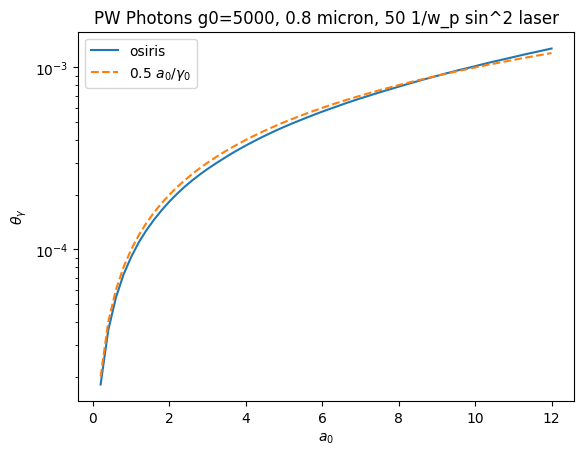

In [3]:
plt.plot(a0lst, thg_osiris, label=r'osiris')
plt.plot(a0lst, 0.5*a0lst/5000, '--', label=r'$ 0.5 ~a_0/\gamma_0$')
plt.xlabel(r'$a_0$')
plt.ylabel(r'$\theta_\gamma$')
plt.title(r'PW Photons g0=5000, 0.8 micron, 50 1/w_p sin^2 laser')
plt.legend()
plt.yscale('log')
plt.show()

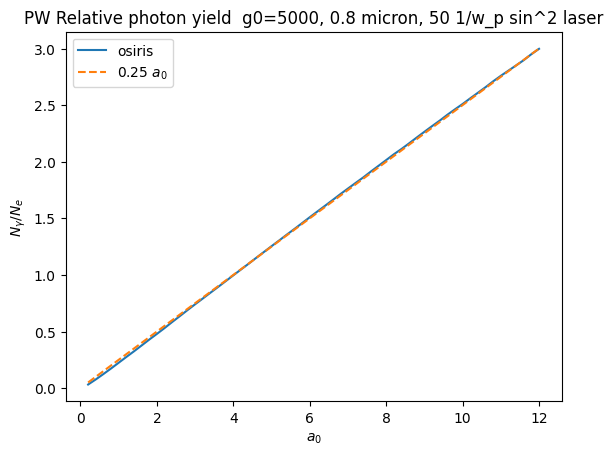

In [4]:
# number of photons, raw_fraction = 1.0
plt.plot(a0lst, Ng_osiris/Ne_osiris, label=r'osiris')
plt.plot(a0lst, 0.25*a0lst, '--', label=r'$0.25 ~a_0$')
plt.xlabel(r'$a_0$')
plt.ylabel(r'$N_\gamma/N_e$')
plt.title(r'PW Relative photon yield  g0=5000, 0.8 micron, 50 1/w_p sin^2 laser')
plt.legend()
plt.show()

In [5]:
# parameters
# laser
lbd = 0.8; #[\mu m]
a0 = 12 #[]
W0 = 2.4; #[\mu m]
zR = pi*W0**2/lbd; #[\mu m]

# beam
g0 = 5000; #[]

def dNda_prp(a, dprp, W0R):
    R = W0/W0R; #[\mu m]
    return (W0/R)**2 / a * ( (a/a0)**((W0/R)**2) ) * iv(0,2*dprp*W0/R**2 * sqrt(log(a0/a))) * exp(-(dprp/R)**2);
dNda_prp = np.vectorize(dNda_prp)

def dNda_pll(a, dpll, W0R):
    R = W0/W0R; #[\mu m]
    fact = np.sqrt(1+(dpll/ (zR*18.85/2.4)  )**2 )
    W = W0*fact
    a0max = a0/fact
    if a <= a0max: #0.5*dpll <= zR*np.sqrt(a0**2/a**2-1):
        return (W0/R)**2 /a * (a/a0 * fact)**((W0/R)**2 * fact**2)
    else:
        return 0
dNda_pll = np.vectorize(dNda_pll)

def get_thg_prp(x, W0R):
    R = W0/W0R; #[\mu m]
    dprp = x * R
    a0lst = np.linspace(1e-3,12,400)
    dNda = np.array([dNda_prp(a, dprp, W0R) for a in a0lst])
    thgPW = 0.5*a0lst/g0
    Ng = 0.25*a0lst
    return sqrt( np.trapz(thgPW**2 * Ng * dNda, a0lst) / np.trapz(Ng * dNda, a0lst) )
    
def get_thg_pll(x, W0R):
    dpll = x * 178 # 178 is used to convert from OSIRIS units
    a0lst = np.linspace(1e-3,12,400)
    dNda = np.array([dNda_pll(a, dpll, W0R) for a in a0lst])
    thgPW = 0.5*a0lst/g0
    Ng = 0.25*a0lst
    return sqrt( np.trapz(thgPW**2 * Ng * dNda, a0lst) / np.trapz(Ng * dNda, a0lst) )

In [6]:
# # synchronized Gaussian, varying W0/R
################################################
thgG_x = np.array([3, 1, 1/3])
thgG = np.zeros(3)
file = h5py.File('Gaussian/RW0_03_RAW-photons-000600.h5', 'r')
enedist = np.array(file['ene'])
qdist = np.array(file['q'])
p1dist = np.array(file['p1'])
p2dist = np.array(file['p2'])
p3dist = np.array(file['p3'])
thdist = np.arctan2(sqrt(p2dist**2), p1dist)
thgG[0] = sqrt(np.sum(thdist**2 * qdist)/np.sum(qdist))

file = h5py.File('Gaussian/RW0_10_RAW-photons-000600.h5', 'r')
enedist = np.array(file['ene'])
qdist = np.array(file['q'])
p1dist = np.array(file['p1'])
p2dist = np.array(file['p2'])
p3dist = np.array(file['p3'])
thdist = np.arctan2(sqrt(p2dist**2), p1dist)
thgG[1] = sqrt(np.sum(thdist**2 * qdist)/np.sum(qdist))

file = h5py.File('Gaussian/RW0_30_RAW-photons-000600.h5', 'r')
enedist = np.array(file['ene'])
qdist = np.array(file['q'])
p1dist = np.array(file['p1'])
p2dist = np.array(file['p2'])
p3dist = np.array(file['p3'])
thdist = np.arctan2(sqrt(p2dist**2), p1dist)
thgG[2] = sqrt(np.sum(thdist**2 * qdist)/np.sum(qdist))

################################################
# Delta_pll Gaussian
################################################
thgDpll_x = np.array([0, 1/2, 1, 3/2])
thgDpll = np.zeros(len(thgDpll_x))
file = h5py.File('GaussianDeltaPll/deltapll000_RAW-photons-000600.h5', 'r')
enedist = np.array(file['ene'])
qdist = np.array(file['q'])
p1dist = np.array(file['p1'])
p2dist = np.array(file['p2'])
p3dist = np.array(file['p3'])
thdist = np.arctan2(sqrt(p2dist**2), p1dist)
thgDpll[0] = sqrt(np.sum(thdist**2 * qdist)/np.sum(qdist))
#
file = h5py.File('GaussianDeltaPll/deltapll089_RAW-photons-000600.h5', 'r')
enedist = np.array(file['ene'])
qdist = np.array(file['q'])
p1dist = np.array(file['p1'])
p2dist = np.array(file['p2'])
p3dist = np.array(file['p3'])
thdist = np.arctan2(sqrt(p2dist**2), p1dist)
thgDpll[1] = sqrt(np.sum(thdist**2 * qdist)/np.sum(qdist))
#
file = h5py.File('GaussianDeltaPll/deltapll178_RAW-photons-000600.h5', 'r')
enedist = np.array(file['ene'])
qdist = np.array(file['q'])
p1dist = np.array(file['p1'])
p2dist = np.array(file['p2'])
p3dist = np.array(file['p3'])
thdist = np.arctan2(sqrt(p2dist**2), p1dist)
thgDpll[2] = sqrt(np.sum(thdist**2 * qdist)/np.sum(qdist))
#
file = h5py.File('GaussianDeltaPll/deltapll267_RAW-photons-000600.h5', 'r')
enedist = np.array(file['ene'])
qdist = np.array(file['q'])
p1dist = np.array(file['p1'])
p2dist = np.array(file['p2'])
p3dist = np.array(file['p3'])
thdist = np.arctan2(sqrt(p2dist**2), p1dist)
thgDpll[3] = sqrt(np.sum(thdist**2 * qdist)/np.sum(qdist))

################################################
# Delta_prp Gaussian
################################################
thgDprp_x = np.array([0, 1, 2, 3])/sqrt(2)
thgDprp = np.zeros(len(thgDprp_x))
file = h5py.File('GaussianDeltaPrp/deltaprp_RW1_dR0_RAW-photons-000060.h5', 'r')
enedist = np.array(file['ene'])
qdist = np.array(file['q'])
p1dist = np.array(file['p1'])
p2dist = np.array(file['p2'])
p3dist = np.array(file['p3'])
thdist = np.arctan2(sqrt(p3dist**2), p1dist)
thgDprp[0] = sqrt(np.sum(thdist**2 * qdist)/np.sum(qdist))
#
file = h5py.File('GaussianDeltaPrp/deltaprp_RW1_dR1_RAW-photons-000060.h5', 'r')
enedist = np.array(file['ene'])
qdist = np.array(file['q'])
p1dist = np.array(file['p1'])
p2dist = np.array(file['p2'])
p3dist = np.array(file['p3'])
thdist = np.arctan2(sqrt(p3dist**2), p1dist)
thgDprp[1] = sqrt(np.sum(thdist**2 * qdist)/np.sum(qdist))
#
file = h5py.File('GaussianDeltaPrp/deltaprp_RW1_dR2_RAW-photons-000060.h5', 'r')
enedist = np.array(file['ene'])
qdist = np.array(file['q'])
p1dist = np.array(file['p1'])
p2dist = np.array(file['p2'])
p3dist = np.array(file['p3'])
thdist = np.arctan2(sqrt(p3dist**2), p1dist)
thgDprp[2] = sqrt(np.sum(thdist**2 * qdist)/np.sum(qdist))
#
file = h5py.File('GaussianDeltaPrp/deltaprp_RW1_dR3_RAW-photons-000060.h5', 'r')
enedist = np.array(file['ene'])
qdist = np.array(file['q'])
p1dist = np.array(file['p1'])
p2dist = np.array(file['p2'])
p3dist = np.array(file['p3'])
thdist = np.arctan2(sqrt(p3dist**2), p1dist)
thgDprp[3] = sqrt(np.sum(thdist**2 * qdist)/np.sum(qdist))

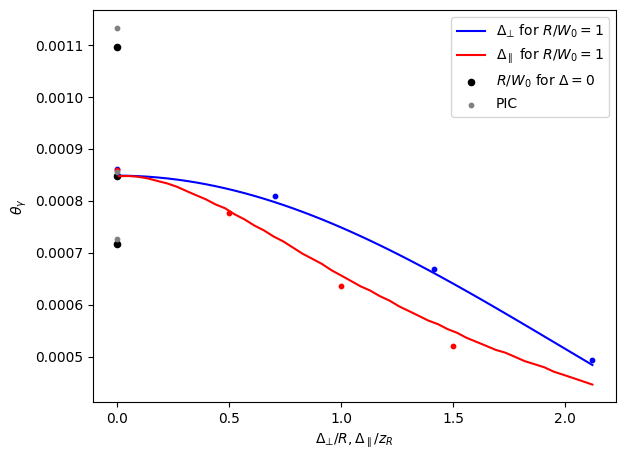

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(18,4.7))

xlst = np.linspace(0.01,3/sqrt(2),50)
plt.plot(xlst, np.array([get_thg_prp(x,1) for x in xlst]), color='blue', label=r'$\Delta_\bot$ for $R/W_0=1$')
plt.plot(xlst, np.array([get_thg_pll(x,1) for x in xlst]), color='red', label=r'$\Delta_\parallel$ for $R/W_0=1$')
plt.scatter(thgDprp_x, thgDprp, s=10, color='blue')
plt.scatter(thgDpll_x, thgDpll, s=10, color='red')
plt.scatter(np.array([0,0,0]), a0/(2*g0) * sqrt((thgG_x**2+1)/(thgG_x**2+3)), s=20, color='k', label=r'$R/W_0$ for $\Delta=0$')
plt.scatter(np.array([0,0,0]), thgG, s=10, color='grey', label=r'PIC')
plt.xlabel(r'$\Delta_\bot/R, \Delta_\parallel/z_R$')
plt.ylabel(r'$\theta_\gamma$')
plt.legend()

axes.set_box_aspect(aspect=3/4)
plt.tight_layout()
#plt.savefig('thetaPhotons.pdf',transparent=True)
plt.show()

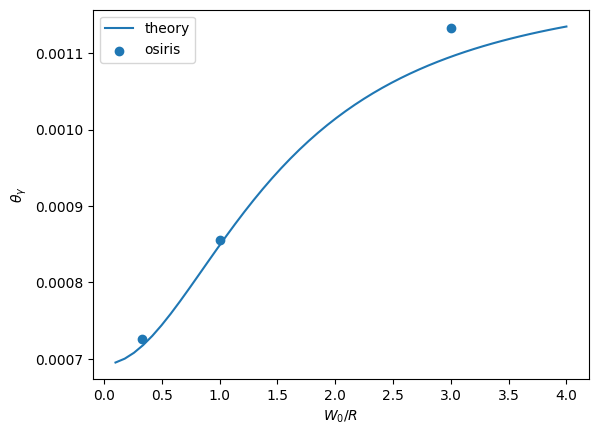

In [8]:
W0Rlst = np.linspace(0.1,4)
plt.plot(W0Rlst, a0/(2*g0) * sqrt((W0Rlst**2+1)/(W0Rlst**2+3)), label=r'theory')
plt.scatter(thgG_x, thgG, label=r'osiris')
plt.xlabel(r'$W_0/R$')
plt.ylabel(r'$\theta_\gamma$')
plt.legend()
plt.show()

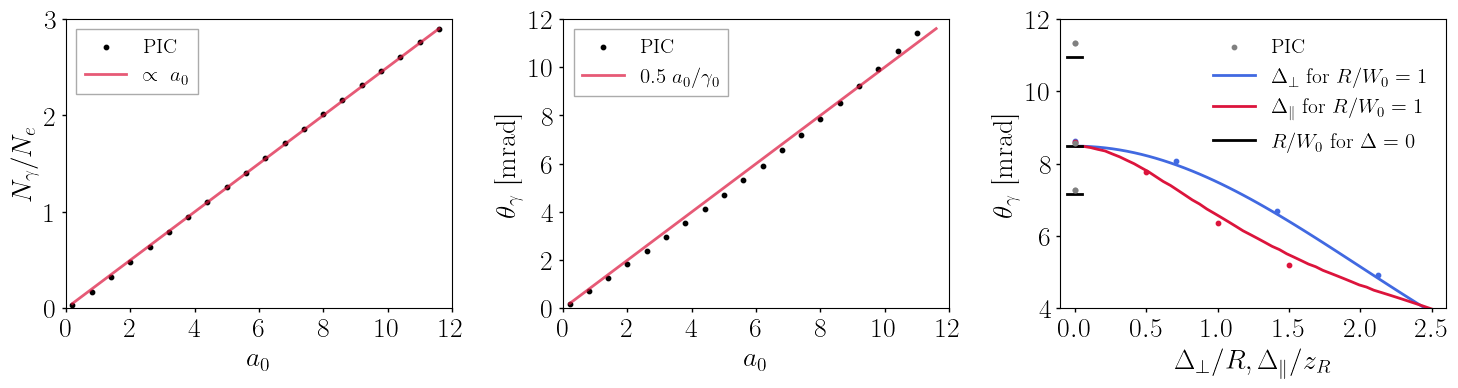

In [5]:
# plot all
plt.style.use("../reduQED/style.txt")
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))

# number of photons, raw_fraction = 1.0
indx = 3
axes[0].scatter(a0lst[::indx], (Ng_osiris/Ne_osiris)[::indx], s=10, color='k', label=r'PIC', zorder=-1)
axes[0].plot(a0lst[::indx], 0.25*a0lst[::indx], '-', label=r'$\propto ~a_0$', alpha=0.7) #0.25 ~a_0
axes[0].set_xlabel(r'$a_0$')
axes[0].set_ylabel(r'$N_\gamma/N_e$')
#axes[0].title(r'PW Relative photon yield  g0=5000, 0.8 micron, 50 1/w_p sin^2 laser')
axes[0].legend(loc='upper left')
axes[0].set_xticks(np.arange(0,13,2))
axes[0].set_ylim([0,3])

mlt = 1e4
axes[1].scatter(a0lst[::indx], mlt*thg_osiris[::indx], s=10, color='k', label=r'PIC', zorder=-1)
axes[1].plot(a0lst[::indx], mlt*0.5*a0lst[::indx]/5000, '-', label=r'$ 0.5 ~a_0/\gamma_0$', alpha=0.7)
axes[1].set_xlabel(r'$a_0$')
axes[1].set_ylabel(r'$\theta_\gamma$ [mrad]')
#axes[1].title(r'PW Photons g0=5000, 0.8 micron, 50 1/w_p sin^2 laser')
axes[1].legend(loc='upper left')
#axes[1].set_yscale('log')
axes[1].set_xticks(np.arange(0,13,2))
axes[1].set_ylim([0,12])
axes[1].set_yticks(np.arange(0,13,2))

mlt = 1e4
xlst = np.linspace(0.01,2.5,50)
xlst2 = np.linspace(-0.1, 0.1)/2
axes[2].scatter(np.array([0,0,0]), mlt*thgG, s=10, color='grey', label=r'PIC')
axes[2].plot(xlst, mlt*np.array([get_thg_prp(x,1) for x in xlst]), color='royalblue', label=r'$\Delta_\bot$ for $R/W_0=1$', zorder=-1)
axes[2].plot(xlst, mlt*np.array([get_thg_pll(x,1) for x in xlst]), color='crimson', label=r'$\Delta_\parallel$ for $R/W_0=1$', zorder=-1)
axes[2].scatter(thgDprp_x, mlt*thgDprp, s=10, color='royalblue')
axes[2].scatter(thgDpll_x, mlt*thgDpll, s=10, color='crimson')
axes[2].plot(xlst2, xlst2*0 + mlt*a0/(2*g0) * sqrt((thgG_x[0]**2+1)/(thgG_x[0]**2+3)), color='k', label=r'$R/W_0$ for $\Delta=0$', zorder=-1)
axes[2].plot(xlst2, xlst2*0 + mlt*a0/(2*g0) * sqrt((thgG_x[1]**2+1)/(thgG_x[1]**2+3)), color='k', zorder=-1)
axes[2].plot(xlst2, xlst2*0 + mlt*a0/(2*g0) * sqrt((thgG_x[2]**2+1)/(thgG_x[2]**2+3)), color='k', zorder=-1)
axes[2].scatter(np.array([0,0,0]), mlt*thgG, s=10, color='grey')
axes[2].set_xlabel(r'$\Delta_\bot/R, \Delta_\parallel/z_R$')
axes[2].set_ylabel(r'$\theta_\gamma$ [mrad]')
axes[2].legend(frameon=False, prop={'size': 15})
axes[2].set_xlim([-0.1,2.6])
axes[2].set_ylim([4,12])
axes[2].set_xticks(np.arange(0,3,0.5))

#axes.set_box_aspect(aspect=3/4)
# aspect
for i in range(3):
    xmin, xmax = axes[i].get_xlim()
    ymin, ymax = axes[i].get_ylim()
    #axesratio = (ymax-ymin)/(xmax-xmin)
    axesratio = (ymax-ymin)/(xmax-xmin)
    #axesratio = (np.log10(ymax)-np.log10(ymin))/(xmax-xmin)
    axes[i].set_aspect(aspect=3/4/axesratio)

plt.tight_layout()
#plt.savefig('thetaPhotons.pdf',transparent=True)
plt.show()

# PW $\theta_e$

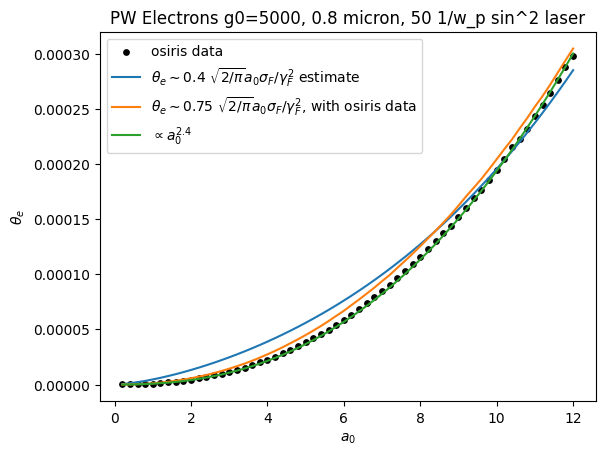

In [11]:
plt.scatter(a0lst, the_osiris, s=15, color='k', label=r'osiris data')
plt.plot(a0lst, 0.28*get_PW_thF(5000,a0lst,0.8,50/2.3545), label=r'$\theta_e \sim 0.4~\sqrt{2/\pi} a_0 \sigma_F/\gamma_F^2$ estimate')
plt.plot(a0lst, 0.75 *sqrt(2/pi)*a0lst*sige_osiris/avge_osiris**2, '-', label=r'$\theta_e \sim 0.75~\sqrt{2/\pi} a_0 \sigma_F/\gamma_F^2$, with osiris data')
plt.plot(a0lst, 3e-4*(a0lst/12)**2.4, '-', label=r'$\propto a_0^{2.4}$')
plt.xlabel(r'$a_0$')
plt.ylabel(r'$\theta_e$')
#plt.yscale('log')
plt.legend()
plt.title(r'PW Electrons g0=5000, 0.8 micron, 50 1/w_p sin^2 laser')
plt.show()

In [12]:
def get_the_prp(x, W0R):
    R = W0/W0R; #[\mu m]
    dprp = x * R
    a0lst = np.linspace(1e-3,12,400)
    dNda = np.array([dNda_prp(a, dprp, W0R) for a in a0lst])
    #thePW = 3e-4*(a0lst/12)**2.4 #0.4*reduQED.get_PW_thF(5000,a0lst,0.8,21.3) #
    thePW = get_PW_thF(5000,a0lst,0.8,21.3)
    return sqrt( np.trapz(thePW**2 * dNda, a0lst) / np.trapz(dNda, a0lst) )
    
def get_the_pll(x, W0R):
    dpll = x * 178 # 178 is used to convert from OSIRIS units
    a0lst = np.linspace(1e-3,12,400)
    dNda = np.array([dNda_pll(a, dpll, W0R) for a in a0lst])
    #thePW = 3e-4*(a0lst/12)**2.4 #0.4*reduQED.get_PW_thF(5000,a0lst,0.8,21.3) #
    thePW = get_PW_thF(5000,a0lst,0.8,21.3)
    return sqrt( np.trapz(thePW**2 * dNda, a0lst) / np.trapz(dNda, a0lst) )

In [13]:
# # synchronized Gaussian, varying W0/R
################################################
theG_x = np.array([3, 1, 1/3])
theG = np.zeros(3)
file = h5py.File('Gaussian/RW0_03_RAW-electrons-000600.h5', 'r')
enedist = np.array(file['ene'])
qdist = np.array(file['q'])
p1dist = np.array(file['p1'])
p2dist = np.array(file['p2'])
p3dist = np.array(file['p3'])
thdist = np.arctan2(sqrt(p2dist**2), p1dist)
theG[0] = sqrt(np.sum(thdist**2 * qdist)/np.sum(qdist))

file = h5py.File('Gaussian/RW0_10_RAW-electrons-000600.h5', 'r')
enedist = np.array(file['ene'])
qdist = np.array(file['q'])
p1dist = np.array(file['p1'])
p2dist = np.array(file['p2'])
p3dist = np.array(file['p3'])
thdist = np.arctan2(sqrt(p2dist**2), p1dist)
theG[1] = sqrt(np.sum(thdist**2 * qdist)/np.sum(qdist))

file = h5py.File('Gaussian/RW0_30_RAW-electrons-000600.h5', 'r')
enedist = np.array(file['ene'])
qdist = np.array(file['q'])
p1dist = np.array(file['p1'])
p2dist = np.array(file['p2'])
p3dist = np.array(file['p3'])
thdist = np.arctan2(sqrt(p2dist**2), p1dist)
theG[2] = sqrt(np.sum(thdist**2 * qdist)/np.sum(qdist))

################################################
# Delta_pll Gaussian
################################################
theDpll_x = np.array([0, 1/2, 1, 3/2])
theDpll = np.zeros(len(theDpll_x))
file = h5py.File('GaussianDeltaPll/deltapll000_RAW-electrons-000600.h5', 'r')
enedist = np.array(file['ene'])
qdist = np.array(file['q'])
p1dist = np.array(file['p1'])
p2dist = np.array(file['p2'])
p3dist = np.array(file['p3'])
thdist = np.arctan2(sqrt(p2dist**2), p1dist)
theDpll[0] = sqrt(np.sum(thdist**2 * qdist)/np.sum(qdist))
#
file = h5py.File('GaussianDeltaPll/deltapll089_RAW-electrons-000600.h5', 'r')
enedist = np.array(file['ene'])
qdist = np.array(file['q'])
p1dist = np.array(file['p1'])
p2dist = np.array(file['p2'])
p3dist = np.array(file['p3'])
thdist = np.arctan2(sqrt(p2dist**2), p1dist)
theDpll[1] = sqrt(np.sum(thdist**2 * qdist)/np.sum(qdist))
#
file = h5py.File('GaussianDeltaPll/deltapll178_RAW-electrons-000600.h5', 'r')
enedist = np.array(file['ene'])
qdist = np.array(file['q'])
p1dist = np.array(file['p1'])
p2dist = np.array(file['p2'])
p3dist = np.array(file['p3'])
thdist = np.arctan2(sqrt(p2dist**2), p1dist)
theDpll[2] = sqrt(np.sum(thdist**2 * qdist)/np.sum(qdist))
#
file = h5py.File('GaussianDeltaPll/deltapll267_RAW-electrons-000600.h5', 'r')
enedist = np.array(file['ene'])
qdist = np.array(file['q'])
p1dist = np.array(file['p1'])
p2dist = np.array(file['p2'])
p3dist = np.array(file['p3'])
thdist = np.arctan2(sqrt(p2dist**2), p1dist)
theDpll[3] = sqrt(np.sum(thdist**2 * qdist)/np.sum(qdist))

################################################
# Delta_prp Gaussian
################################################
theDprp_x = np.array([0, 1, 2, 3])/sqrt(2)
theDprp = np.zeros(len(theDprp_x))
file = h5py.File('GaussianDeltaPrp/deltaprp_RW1_dR0_RAW-electrons-000060.h5', 'r')
enedist = np.array(file['ene'])
qdist = np.array(file['q'])
p1dist = np.array(file['p1'])
p2dist = np.array(file['p2'])
p3dist = np.array(file['p3'])
thdist = np.arctan2(sqrt(p3dist**2), p1dist)#+p3dist**2
theDprp[0] = sqrt(np.sum(thdist**2 * qdist)/np.sum(qdist))
#
file = h5py.File('GaussianDeltaPrp/deltaprp_RW1_dR1_RAW-electrons-000060.h5', 'r')
enedist = np.array(file['ene'])
qdist = np.array(file['q'])
p1dist = np.array(file['p1'])
p2dist = np.array(file['p2'])
p3dist = np.array(file['p3'])
thdist = np.arctan2(sqrt(p3dist**2), p1dist)#+p3dist**2
theDprp[1] = sqrt(np.sum(thdist**2 * qdist)/np.sum(qdist))
#
file = h5py.File('GaussianDeltaPrp/deltaprp_RW1_dR2_RAW-electrons-000060.h5', 'r')
enedist = np.array(file['ene'])
qdist = np.array(file['q'])
p1dist = np.array(file['p1'])
p2dist = np.array(file['p2'])
p3dist = np.array(file['p3'])
thdist = np.arctan2(sqrt(p3dist**2), p1dist)#+p3dist**2
theDprp[2] = sqrt(np.sum(thdist**2 * qdist)/np.sum(qdist))
#
file = h5py.File('GaussianDeltaPrp/deltaprp_RW1_dR3_RAW-electrons-000060.h5', 'r')
enedist = np.array(file['ene'])
qdist = np.array(file['q'])
p1dist = np.array(file['p1'])
p2dist = np.array(file['p2'])
p3dist = np.array(file['p3'])
thdist = np.arctan2(sqrt(p3dist**2), p1dist)#+p3dist**2
theDprp[3] = sqrt(np.sum(thdist**2 * qdist)/np.sum(qdist))

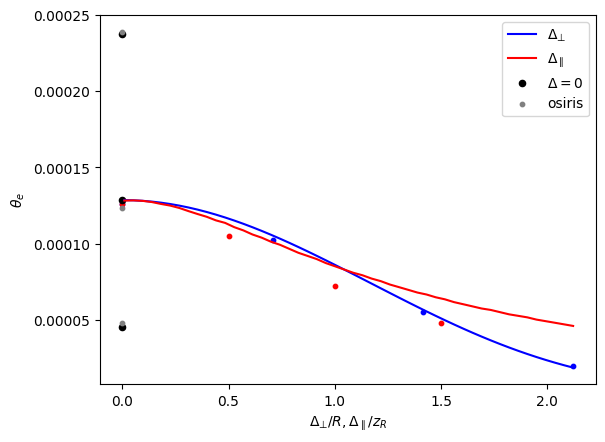

In [12]:
xlst = np.linspace(0.01,3/sqrt(2),50)
plt.plot(xlst, np.array([get_the_prp(x,1) for x in xlst]), color='blue', label=r'$\Delta_\bot$')
plt.plot(xlst, np.array([get_the_pll(x,1) for x in xlst]), color='red', label=r'$\Delta_\parallel$')
plt.scatter(theDprp_x, theDprp, s=10, color='blue')
plt.scatter(theDpll_x, theDpll, s=10, color='red')
plt.scatter(np.array([0,0,0]), [get_the_prp(0,1/3), get_the_prp(0,1), get_the_prp(0,3)], s=20, color='k', label=r'$\Delta=0$')
plt.scatter(np.array([0,0,0]), theG, s=10, color='grey', label=r'osiris')
plt.xlabel(r'$\Delta_\bot/R, \Delta_\parallel/z_R$')
plt.ylabel(r'$\theta_e$')
plt.legend()
plt.show()

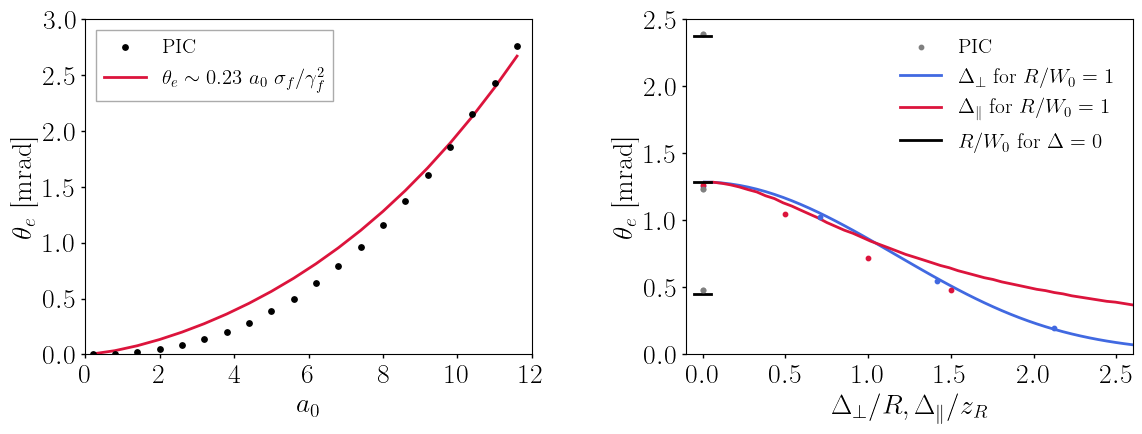

In [25]:
# plot all
plt.style.use("../reduQED/style.txt")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4.5))

mlt = 1e4
indx = 3
axes[0].scatter(a0lst[::indx], mlt*the_osiris[::indx], s=15, color='k', label=r'PIC')
axes[0].plot(a0lst[::indx], mlt*get_PW_thF(5000,a0lst,0.8,50/2.3545)[::indx], label=r'$\theta_e \sim 0.23 ~a_0 ~\sigma_f/\gamma_f^2$', zorder=-1)
#axes[0].plot(a0lst, mlt*0.75*sqrt(2/pi)*a0lst*sige_osiris/avge_osiris**2, '-', label=r'$\theta_e \sim 0.75~\sqrt{2/\pi} a_0 \sigma_F/\gamma_F^2$, with osiris data')
#axes[0].plot(a0lst, mlt*3e-4*(a0lst/12)**2.4, '-', label=r'$\propto a_0^{2.4}$')
axes[0].set_xlabel(r'$a_0$')
axes[0].set_ylabel(r'$\theta_e$ [mrad]')
#axes[0].set_yscale('log')
axes[0].legend(loc='upper left')
axes[0].set_xticks(np.arange(0,13,2))
axes[0].set_ylim([0,3])

mlt = 1e4
xlst2 = np.linspace(-0.1, 0.1)/2
xlst = np.linspace(0.01,2.6,50)
axes[1].scatter(np.array([0,0,0]), mlt*theG, s=10, color='grey', label=r'PIC')
axes[1].plot(xlst, mlt*np.array([get_the_prp(x,1) for x in xlst]), color='royalblue', label=r'$\Delta_\bot$ for $R/W_0=1$', zorder=1)
axes[1].plot(xlst, mlt*np.array([get_the_pll(x,1) for x in xlst]), color='crimson', label=r'$\Delta_\parallel$ for $R/W_0=1$', zorder=1)
axes[1].scatter(theDprp_x, mlt*theDprp, s=10, color='royalblue')
axes[1].scatter(theDpll_x, mlt*theDpll, s=10, color='crimson')
axes[1].plot(xlst2, xlst2*0 + mlt*get_the_prp(0,1/3), color='k', label=r'$R/W_0$ for $\Delta=0$', zorder=1)
axes[1].plot(xlst2, xlst2*0 + mlt*get_the_prp(0,1), color='k')
axes[1].plot(xlst2, xlst2*0 + mlt*get_the_prp(0,3), color='k')
axes[1].scatter(np.array([0,0,0]), mlt*theG, s=10, color='grey')
axes[1].set_xlabel(r'$\Delta_\bot/R, \Delta_\parallel/z_R$')
axes[1].set_ylabel(r'$\theta_e$ [mrad]')
axes[1].legend(frameon=False, prop={'size': 15})
axes[1].set_xlim([-0.1,2.6])
axes[1].set_ylim([0,2.5])
axes[1].set_xticks(np.arange(0,3,0.5))

# aspect
for i in range(2):
    xmin, xmax = axes[i].get_xlim()
    ymin, ymax = axes[i].get_ylim()
    #axesratio = (ymax-ymin)/(xmax-xmin)
    axesratio = (ymax-ymin)/(xmax-xmin)
    #axesratio = (np.log10(ymax)-np.log10(ymin))/(xmax-xmin)
    axes[i].set_aspect(aspect=3/4/axesratio)

plt.tight_layout()
plt.savefig('thetaElectrons.pdf',transparent=True)
plt.show()

In [7]:
0.5*sqrt(1/pi) # ~0.28209479177387814

0.28209479177387814

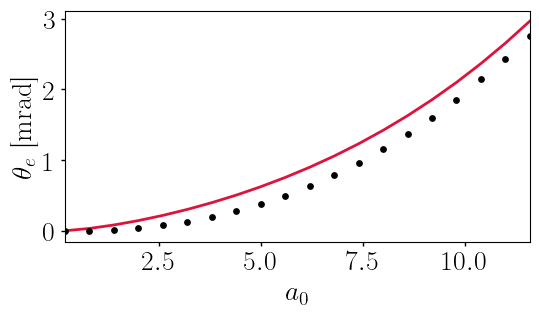

In [70]:
1e4
indx = 3
plt.scatter(a0lst[::indx], mlt*the_osiris[::indx], s=15, color='k', label=r'PIC') #0.5*sqrt(1/pi)
plt.plot(a0lst[::indx], mlt* get_PW_thF(5000,a0lst,0.8,50/2.3545)[::indx], label=r'$\theta_e \sim 0.28 ~a_0 ~\sigma_F/\gamma_F^2$', zorder=-1)
#axes[0].plot(a0lst, mlt*0.75*sqrt(2/pi)*a0lst*sige_osiris/avge_osiris**2, '-', label=r'$\theta_e \sim 0.75~\sqrt{2/\pi} a_0 \sigma_F/\gamma_F^2$, with osiris data')
#axes[0].plot(a0lst, mlt*3e-4*(a0lst/12)**2.4, '-', label=r'$\propto a_0^{2.4}$')
plt.xlabel(r'$a_0$')
plt.ylabel(r'$\theta_e$ [mrad]')
#axes[0].set_yscale('log')
axes[0].legend(loc='upper left')
#plt.xticks(np.arange(0,13,2))
#axes[0].set_ylim([0,3])
#plt.yscale('log')
plt.show()

In [71]:
0.5/sqrt(pi)

0.28209479177387814

In [69]:
def get_PW_sigF(g0,a0,lbd,tau):
    """
        [3] Vranic2016NJP eq 17 energy spread limit LP
        "It is worth noting that the result presented in equation (17) does not depend on the laser polarisation, but solely on intensity and duration."
    """
    
    w_p = 2*pi*c/(lbd) # laser frequency
    ES = m_e**2*c**3/(e*hbar) # Schwinger field
    Eref = m_e*c*w_p/e # normalizing field
    aS = ES/Eref # normalized Schwinger field
    chi = 2*g0*a0/aS
    
    I22 = 1e-4 * (a0/0.855/lbd)**2;
    sigF = sqrt( 1.455e-4 * sqrt(I22) * g0**3/(1+6.12e-5*g0*I22*tau )**3 )
    return sigF

def get_PW_thF(g0,a0,lbd,tau):
    """
        [3] Vranic2016NJP eq ? energy spread limit
        g0[]
        a0[]
        lbd[\mu m]
        tau[fs]
    """
    gF = get_PW_gF(g0, a0, lbd, tau*1e-15);
    sigF = get_PW_sigF(g0, a0, lbd, tau);
    # Vranic2016NJP net beam divergence 
    thF = 0.25* a0 * sigF/gF**2
    return thF
